In [ ]:
# ! pip install vectorbt quantstats pandas numpy matplotlib ta optuna backtesting requests websocket-client asyncio nautilus-trader



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
from binance.client import Client
import pandas as pd

api_key = "YOUR_API_KEY"
api_secret = "YOUR_API_SECRET"

client = Client(api_key, api_secret)  # mainnet
symbol = "BTCUSDT"
interval = Client.KLINE_INTERVAL_1MINUTE
start_str = "1 Nov, 2025"

klines = client.get_historical_klines(symbol, interval, start_str)

df = pd.DataFrame(klines, columns=[
    "open_time","open","high","low","close","volume",
    "close_time","quote_asset_volume","number_of_trades",
    "taker_buy_base_asset_volume","taker_buy_quote_asset_volume","ignore"
])

df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
for col in ["open","high","low","close","volume"]:
    df[col] = df[col].astype(float)

print(df.head())


            open_time       open       high        low      close    volume  \
0 2025-11-01 00:00:00  109608.01  109621.62  109608.00  109616.35   5.65926   
1 2025-11-01 00:01:00  109616.34  109639.64  109550.46  109550.47  47.19536   
2 2025-11-01 00:02:00  109550.46  109550.46  109470.92  109470.93  10.29554   
3 2025-11-01 00:03:00  109470.92  109476.12  109447.00  109447.00  39.15662   
4 2025-11-01 00:04:00  109447.00  109457.94  109441.26  109444.44   4.47815   

               close_time quote_asset_volume  number_of_trades  \
0 2025-11-01 00:00:59.999    620327.34965220              1005   
1 2025-11-01 00:01:59.999   5172298.30687730              2016   
2 2025-11-01 00:02:59.999   1127423.03182360              2208   
3 2025-11-01 00:03:59.999   4286187.85469350              2785   
4 2025-11-01 00:04:59.999    490126.77018130              1443   

  taker_buy_base_asset_volume taker_buy_quote_asset_volume ignore  
0                  3.81740000              418426.01560140  

c:\Users\vibhu\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\vibhu\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\vibhu\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

Epoch 1/5


c:\Users\vibhu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0198 - val_loss: 5.4156e-04
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0051 - val_loss: 3.6689e-04
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0047 - val_loss: 3.8161e-04
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0042 - val_loss: 3.7933e-04
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0037 - val_loss: 3.6739e-04
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


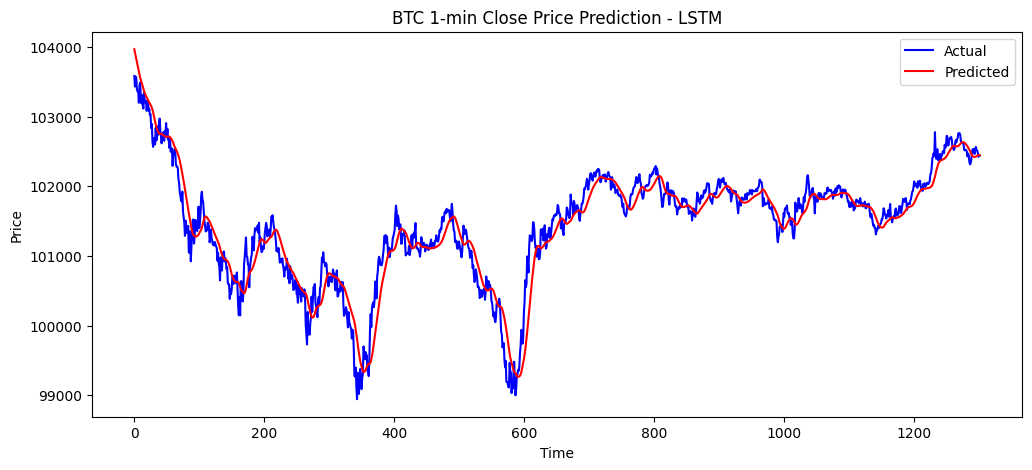

Random Forest RMSE: 2001.2967652245627


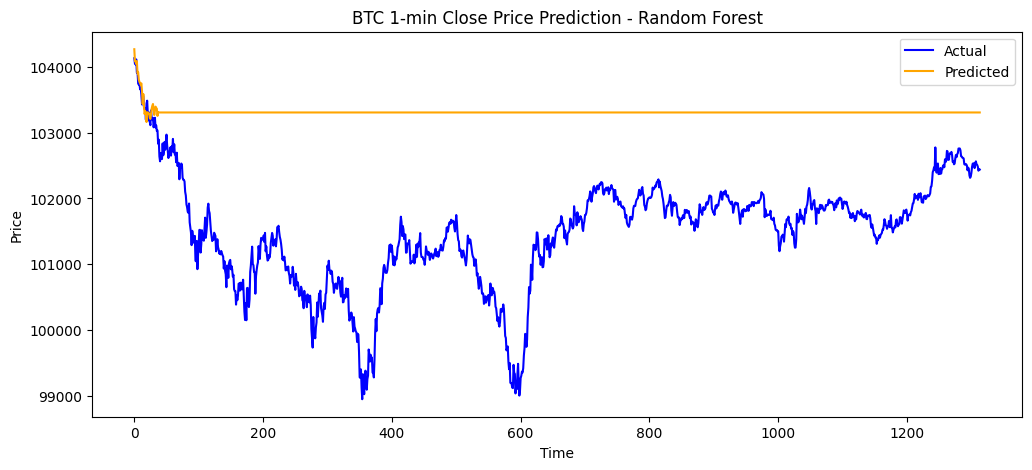

In [9]:
import pandas as pd
import numpy as np
from binance.client import Client
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
# -------------------------------
# 2️⃣ LSTM Preparation
# -------------------------------
# Use close price for prediction
data = df[["close"]].values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, n_steps=60):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 60
X, y = create_sequences(scaled_data, n_steps)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -------------------------------
# 3️⃣ Train LSTM
# -------------------------------
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Predict and inverse scale
y_pred_lstm = model.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_lstm = scaler.inverse_transform(y_test)

# Plot LSTM results
plt.figure(figsize=(12,5))
plt.plot(y_test_lstm, color='blue', label='Actual')
plt.plot(y_pred_lstm, color='red', label='Predicted')
plt.title('BTC 1-min Close Price Prediction - LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# -------------------------------
# 4️⃣ Random Forest Preparation
# -------------------------------
df_rf = df.copy()
for lag in range(1,6):  # past 5 minutes
    df_rf[f"lag_{lag}"] = df_rf["close"].shift(lag)

df_rf.dropna(inplace=True)

X_rf = df_rf[[f"lag_{lag}" for lag in range(1,6)]]
y_rf = df_rf["close"]

# Train-test split
split = int(0.8 * len(X_rf))
X_train_rf, X_test_rf = X_rf[:split], X_rf[split:]
y_train_rf, y_test_rf = y_rf[:split], y_rf[split:]

# -------------------------------
# 5️⃣ Train Random Forest
# -------------------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
print("Random Forest RMSE:", rmse_rf)

# Plot Random Forest results
plt.figure(figsize=(12,5))
plt.plot(y_test_rf.values, color='blue', label='Actual')
plt.plot(y_pred_rf, color='orange', label='Predicted')
plt.title('BTC 1-min Close Price Prediction - Random Forest')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [16]:
import pickle

# Save Random Forest
with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("Random Forest model saved as rf_model.pkl")



Random Forest model saved as rf_model.pkl


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# -------------------------------
# Random Forest Preparation (lags)
# -------------------------------
df_rf = df.copy()
for lag in range(1,6):  # past 5 minutes
    df_rf[f"lag_{lag}"] = df_rf["close"].shift(lag)

df_rf.dropna(inplace=True)

X_rf = df_rf[[f"lag_{lag}" for lag in range(1,6)]]
y_rf = df_rf["close"]

# Train-test split
split = int(0.8 * len(X_rf))
X_train_rf, X_test_rf = X_rf[:split], X_rf[split:]
y_train_rf, y_test_rf = y_rf[:split], y_rf[split:]

# -------------------------------
# Train Random Forest with 300 trees
# -------------------------------
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
print("Random Forest RMSE (300 trees):", rmse_rf)


Random Forest RMSE (300 trees): 1969.3649112946246


In [17]:
import pickle

# Save the new Random Forest
with open("rf_model_300trees.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("Random Forest (300 trees) saved as rf_model_300trees.pkl")


Random Forest (300 trees) saved as rf_model_300trees.pkl


In [18]:
# Save LSTM model
model.save("lstm_model.h5")
print("LSTM model saved as lstm_model.h5")


LSTM model saved as lstm_model.h5


In [ ]:
# Load Random Forest
with open("rf_model_300trees.pkl", "rb") as f:
    loaded_rf = pickle.load(f)

# Load LSTM
from tensorflow.keras.models import load_model
loaded_lstm = load_model("lstm_model.h5")
